# Neural Style Transfer Project

The given project is based on [this paper](https://github.com/saketbyte/AnnotatedPapers/blob/main/NST%20optimisation%20method%20based/Paper%20Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) .
Here I have used pretrained VGG network feature maps to extract -
1. Image content
2. Image style

Then using a linear combination of mean square error between content and target as well as mean square error between Gram matrix of style image and
content image, I am able to derive beautiful artistic style transfer images.




In [127]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In order to get both the content and style representations of our image, we will look at some intermediate layers within our model. Intermediate layers represent feature maps that become increasingly higher ordered as you go deeper. In this case, we are using the network architecture VGG19, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from our images. For an input image, we will try to match the corresponding style and content target representations at these intermediate layers.

Hence we make use of pretrained VGG 19 on ImageNet dataset, to extract the necessary features from the 2 images that we provide.

In [74]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## A helper function to load images.

In [106]:
def load_image(img_path, max_size=500, shape=None):
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the t alpha channel (that's the :3) and adding dimension of batch
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Fill in the location of image below in the braces

In [232]:
# load in content and style image
content = load_image('content 2.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('scream_style.jpg', shape=content.shape[-2:]).to(device)

In [233]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

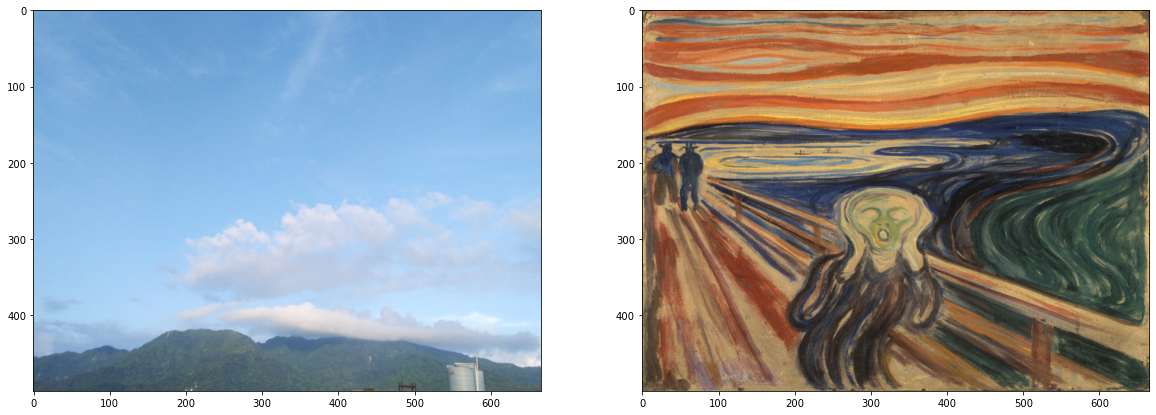

In [234]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

There are few layers mentioned in the paper as mentioned earlier,which are used for feature extraction. Mapping the indexing of the layers in our VGG19 model to more understandable names as follows. Please have a look at the below image.

![image](layers.jpg)

Thus after mapping we extract the feature from these specific layer modules of our network and return them when called.

In [236]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

To obtain a representation of the style of an input image,
we use a feature space designed to capture texture information
[10]. This feature space can be built on top of the filter
responses in any layer of the network. It consists of the correlations
between the different filter responses, where the
expectation is taken over the spatial extent of the feature
maps. These feature correlations are given by the Gram matrix
Gl 2 RNl×Nl , where Gl
ij is the inner product between
the vectorised feature maps i and j in layer l:
![Gram Matrix](Gram.jpg)


In [237]:
def gram_matrix(tensor):
    
    
    # get the batch_size, depth, height, and width of the Tensor
    b, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(b * d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

Here we are calling the functionas defined above to get the features for the content and style image which will later be compared against our target image to calculate loss and bring the 3 feature spaces close to each other, as per the needs.

In [238]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

Since we know that earlier layers store more overall or larger pattern informations, and the later layers in a network include finer and smaller details from the image, we can weight the importance of these layers accordingly. Remember these are not collectively fractioned, instead each layer can have any value between 0 and 1 preferably to do a perfect weighing.

In [240]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1,
                 'conv2_1': 1,
                 'conv3_1': 0.2,
                 'conv4_1': 1,
                 'conv5_1': 1}
content_weight = 2  # alpha
style_weight = 1e15#eta

Till now, the overall process looks somewhat like this


![image2](Process.jpg)

The only difference from the paper that you can find here is the optimizer function used for reaching the results. The paper says to use LBFGS optimizer, however I have tried to implement this using Adam Optimization method which although gives results slower however, requires lesser memory space and makes the heavy processing possible given the constraints.

Total loss:  5.714663581732045e+16


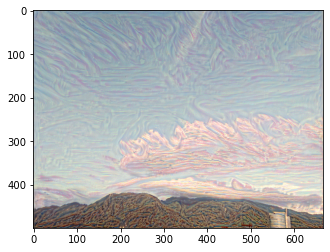

Total loss:  2.268362066572083e+16


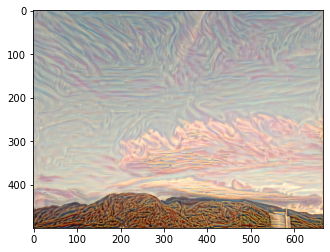

Total loss:  1.3307508416315392e+16


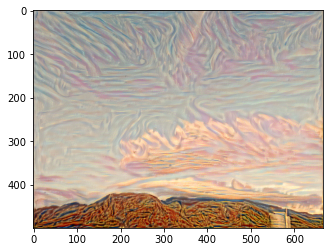

In [241]:
show_every = 512

optimizer = optim.Adam([target], lr=0.003)
steps = 512*5

for ii in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
   
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

In [247]:
# # display content and final, target image
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# ax1.imshow(im_convert(content))
# ax2.imshow(im_convert(target))

In [248]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# ax1.imshow(im_convert(style))
# ax2.imshow(im_convert(target))

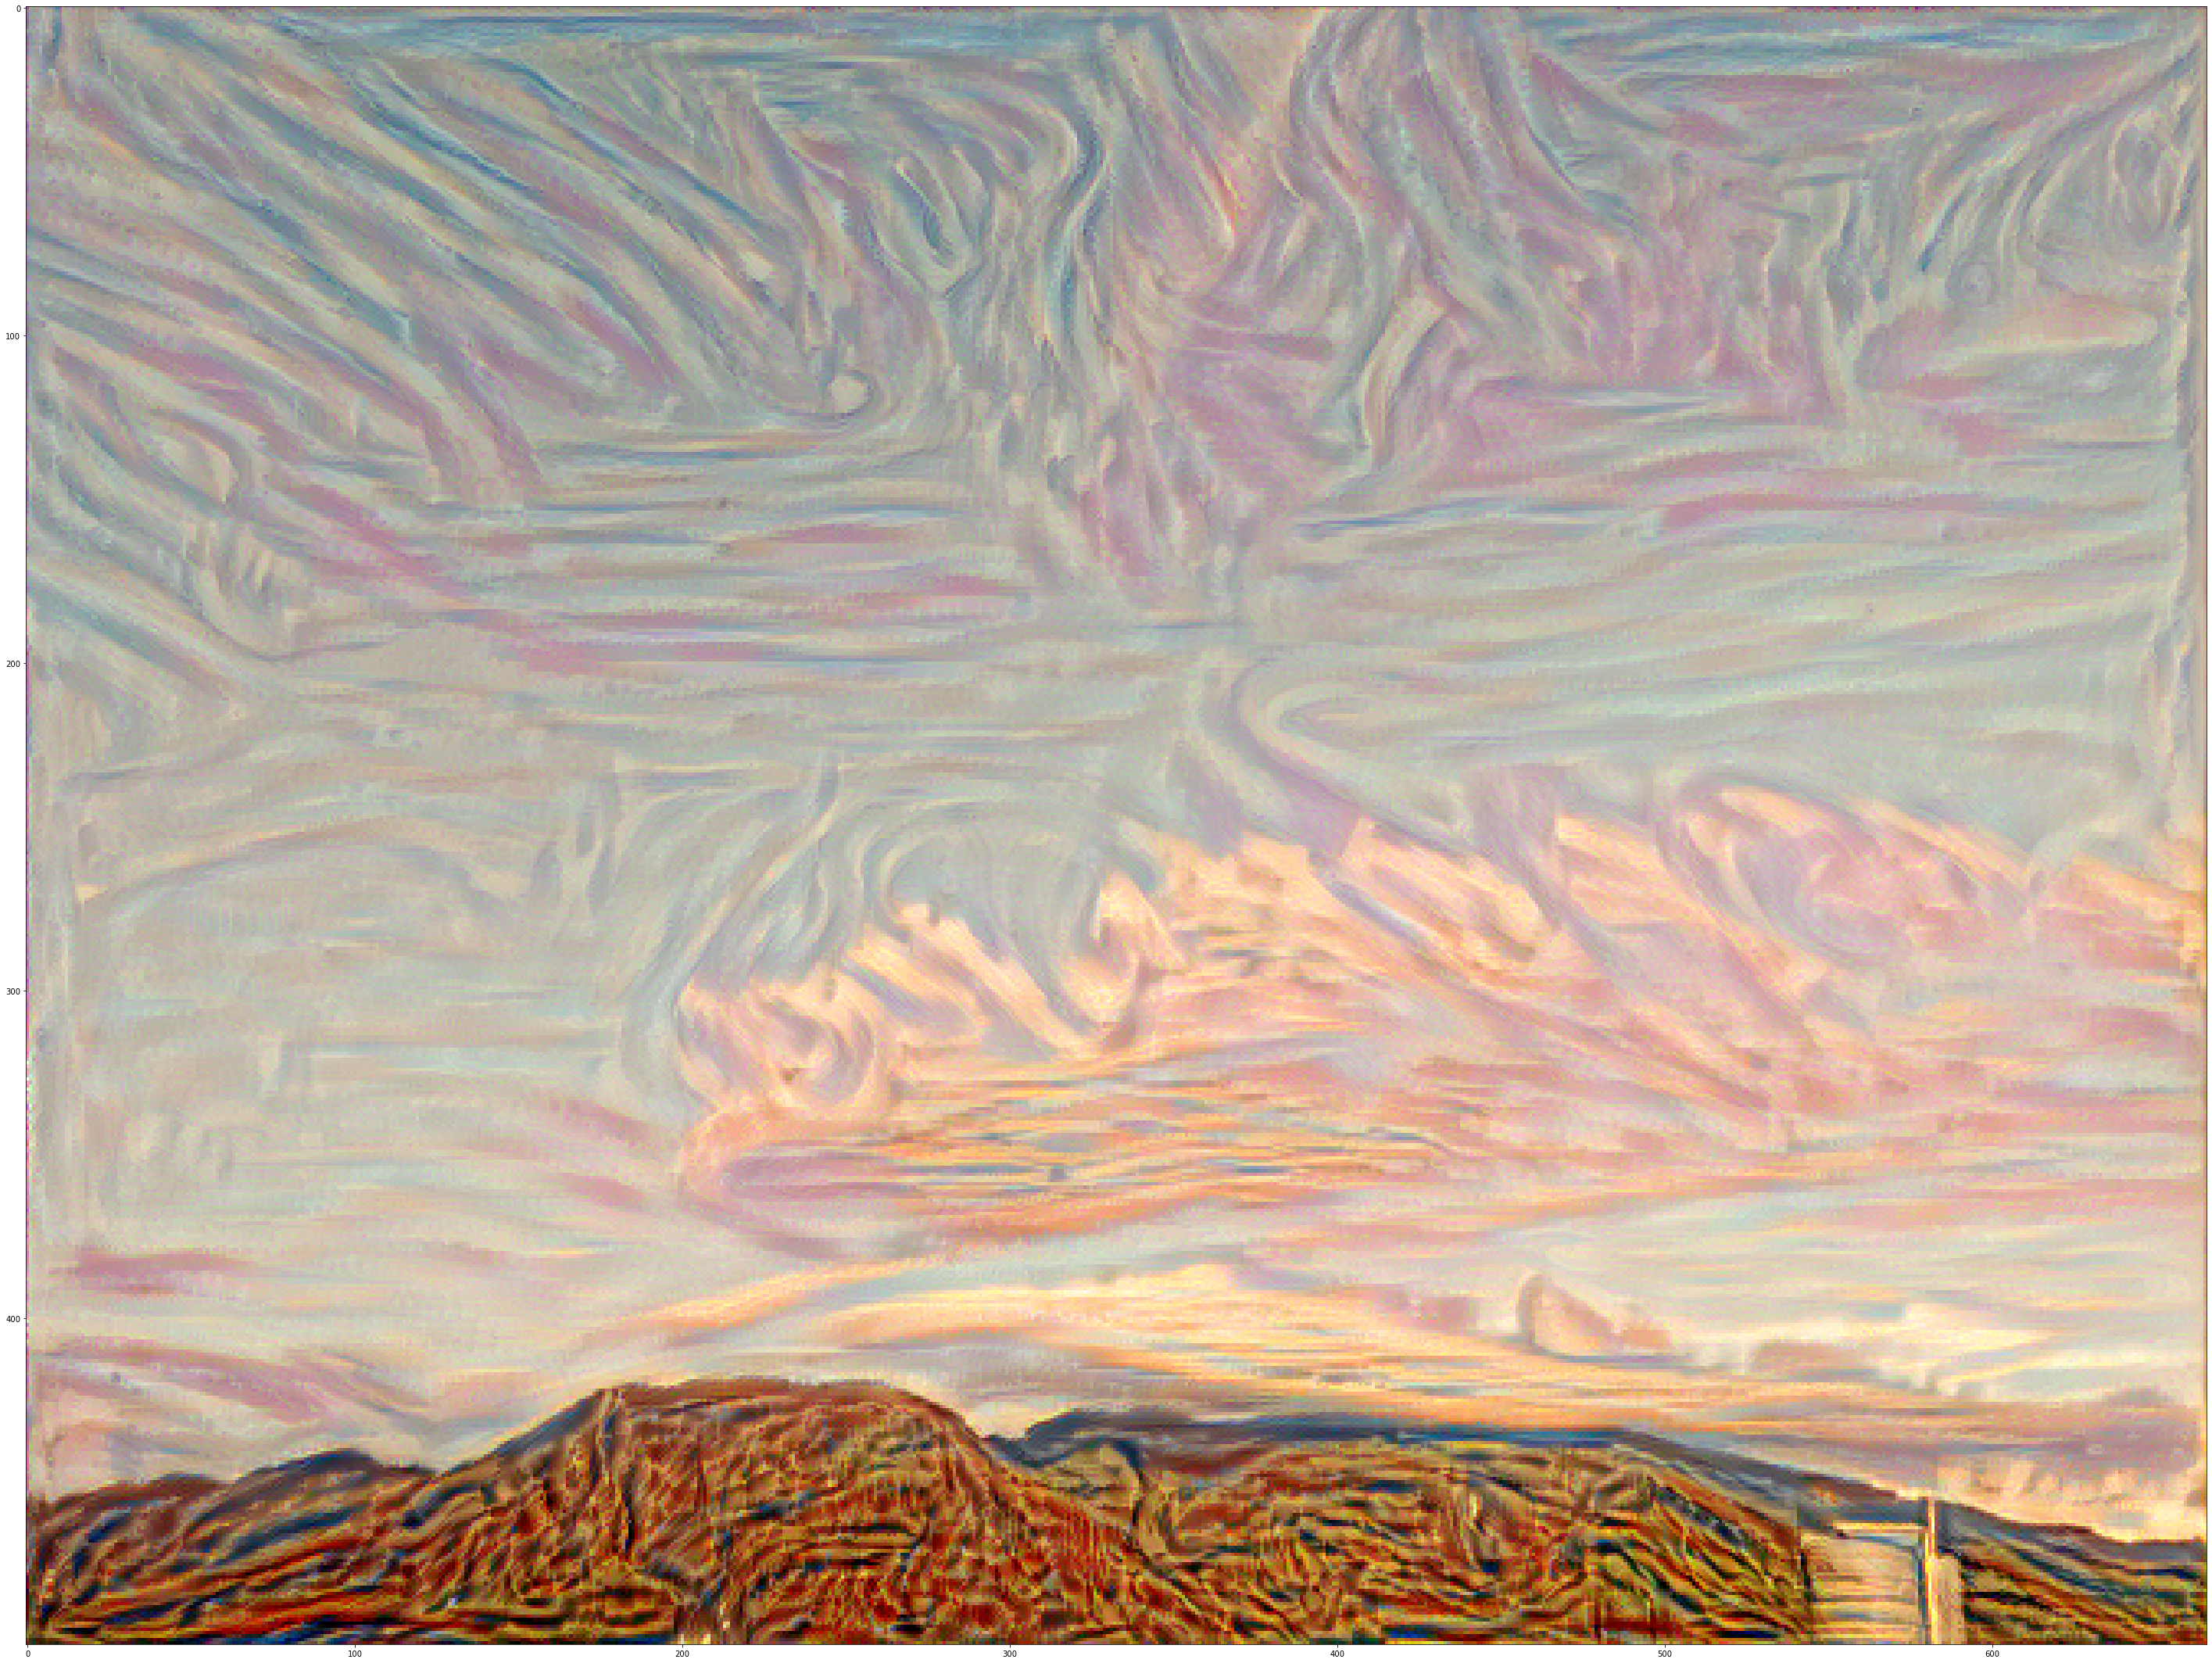

In [244]:
fig, ax = plt.subplots(figsize=(50, 50))
ax.imshow(im_convert(target))

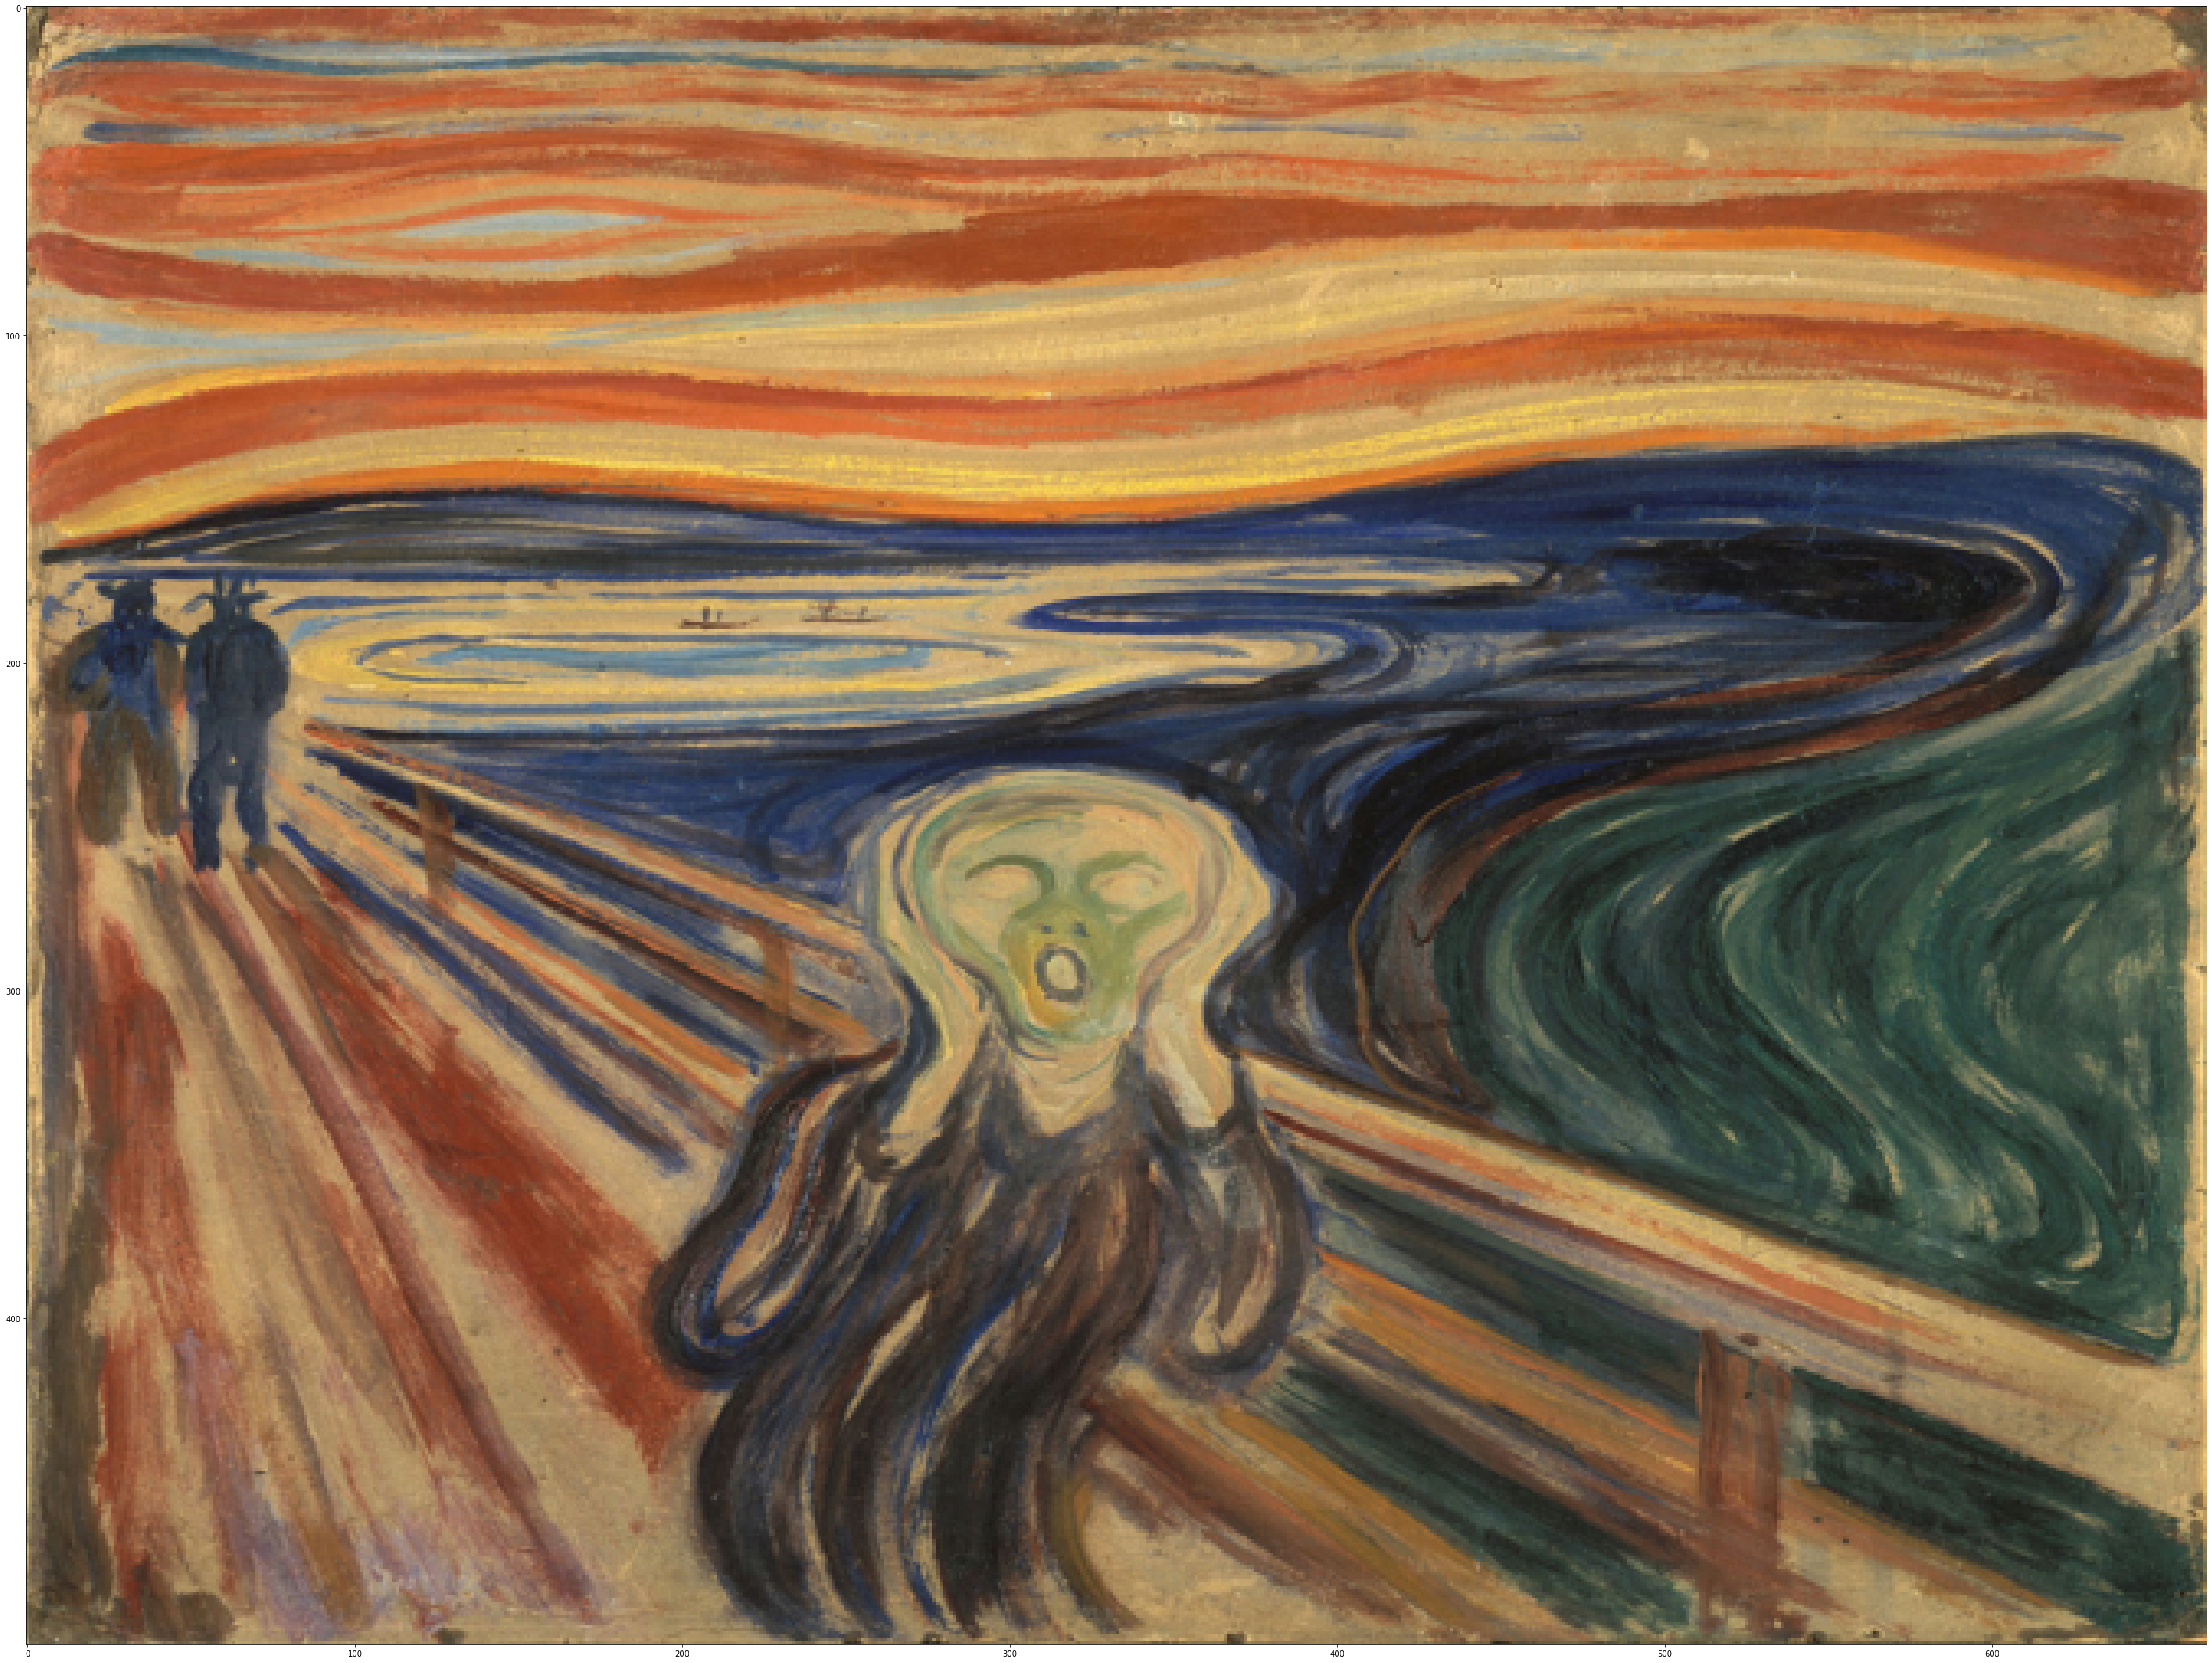

In [245]:
fig, ax = plt.subplots(figsize=(50, 50))
ax.imshow(im_convert(style))

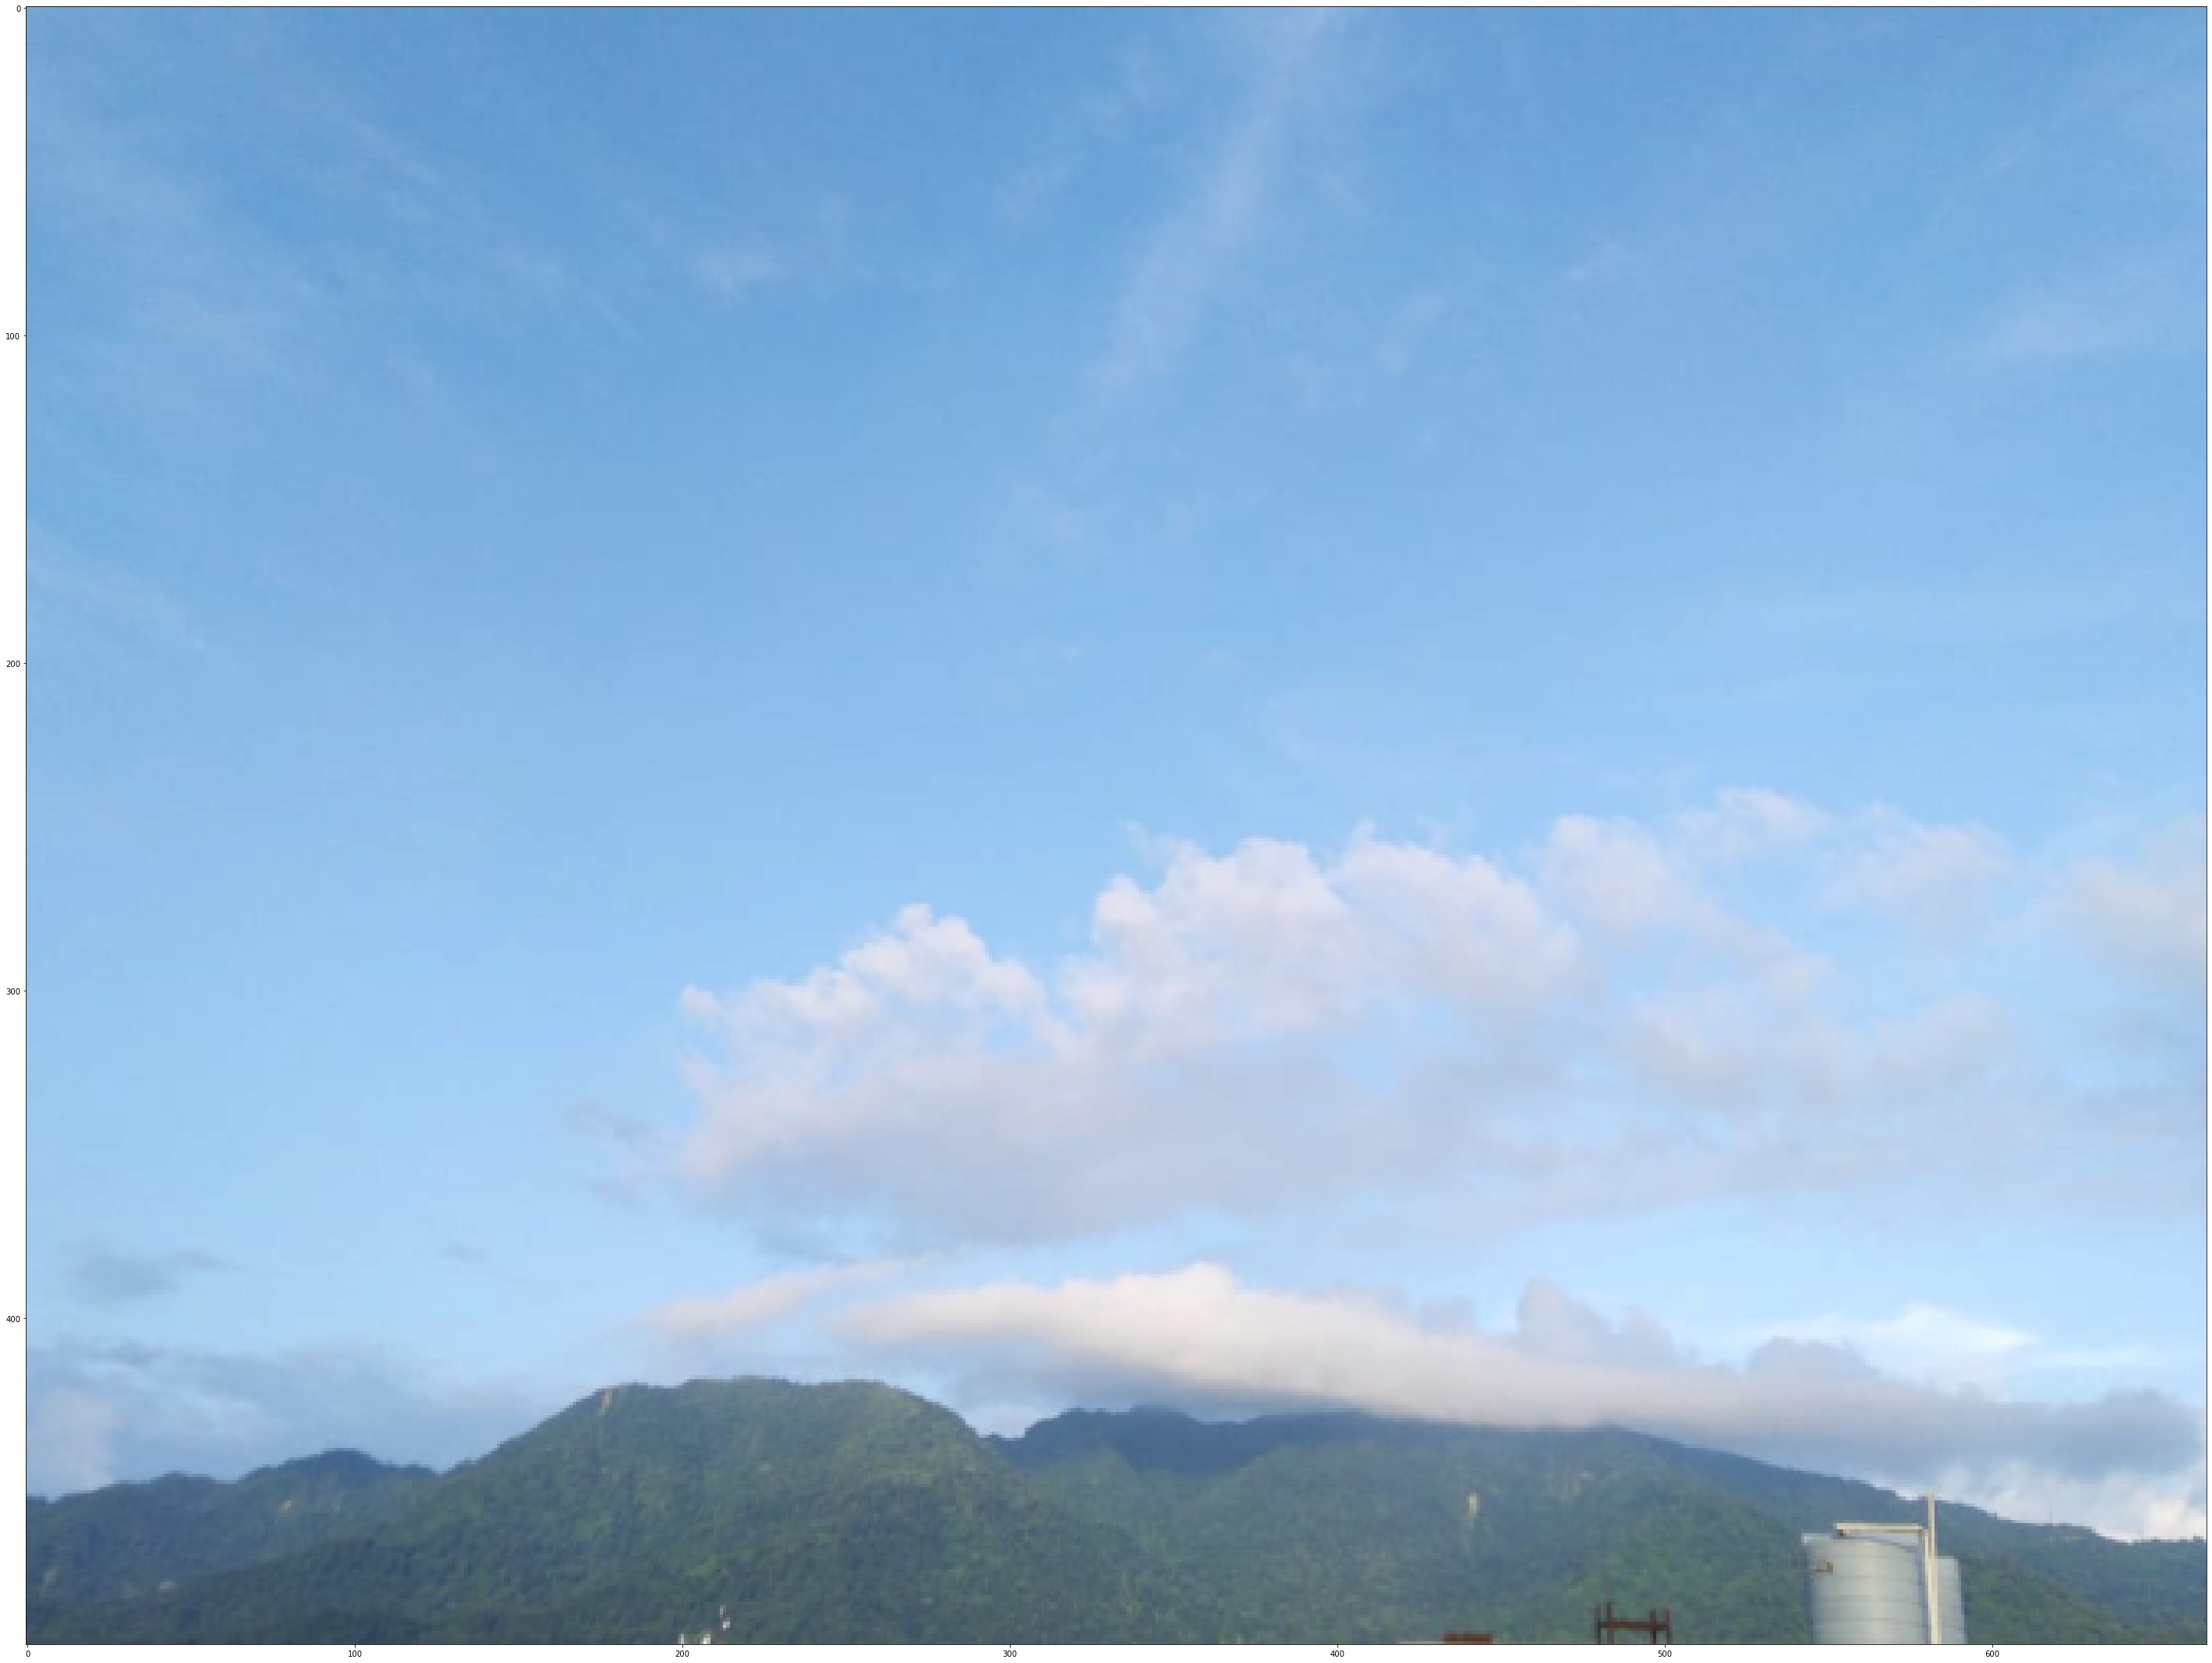

In [246]:
fig, ax = plt.subplots(figsize=(50, 50))
ax.imshow(im_convert(content))